# Boosting to Uniformity

In physics applications frequently we need to achieve uniformity of predictions along some features.
For instance, when testing for the existence of a new particle, we need a classifier to be uniform in background along the mass (otherwise one can get false discovery due to so-called peaking background).

This notebook contains some comparison of classifiers. The target is to obtain flat effiency in __signal__ (without significally loosing quality of classification) in Dalitz features.

The classifiers compared are 

* plain __GradientBoosting__ 
* __uBoost__
* gradient boosting with knn-Ada loss (__UGB+knnAda__) 
* gradient boosting with FlatnessLoss (__UGB+FlatnessLoss__)

We use dataset from paper about `uBoost` for demonstration purposes.
We have a plenty of data here, so results are quite stable

In [1]:
# downloading data
!wget -O ../data/dalitzdata.root -nc https://github.com/arogozhnikov/hep_ml/blob/data/data_to_download/dalitzdata.root?raw=true

File ‘../data/dalitzdata.root’ already there; not retrieving.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier

from hep_ml import gradientboosting as ugb
from hep_ml import uboost
from hep_ml.commonutils import train_test_split
from hep_ml.metrics import BinBasedSDE, KnnBasedCvM

### Loading data

In [3]:
import uproot

used_columns = ["Y1", "Y2", "Y3", "M2AB", "M2AC"]
# Use uproot instead of root_numpy
with uproot.open("../data/dalitzdata.root") as file:
    tree = file["tree"]
    # Read all branches and convert to pandas DataFrame
    data = tree.arrays(library="pd")

labels = data["labels"]
data = data.drop("labels", axis=1)

## Distributions in the Dalitz features for signal and background
As we can see, the background is distributed mostly in the corners of Dalitz plot, <br />
and for traditional classifiers this results in poor effieciency of signal in the corners.

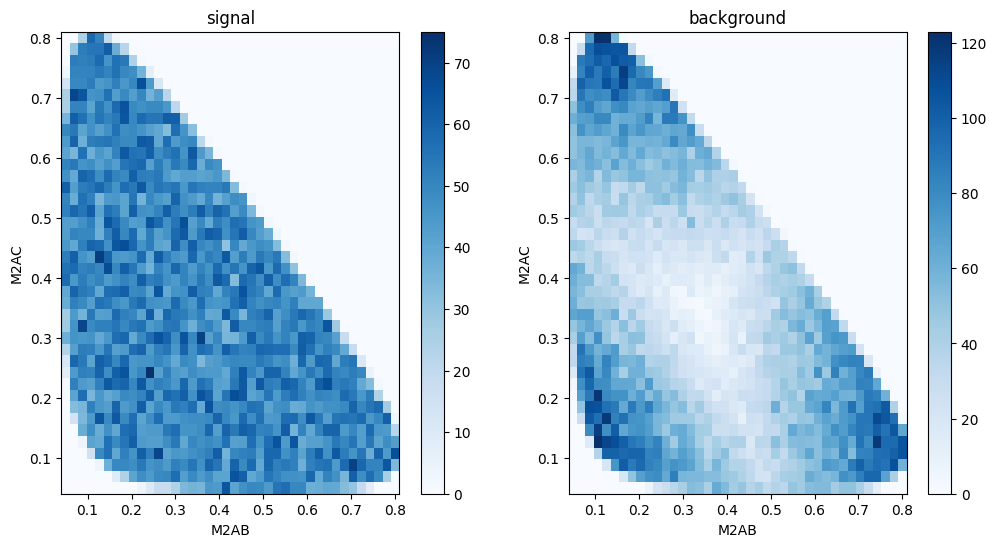

In [4]:
def plot_distribution(data_frame, var_name1="M2AB", var_name2="M2AC", bins=40):
    """The function to plot 2D distribution histograms"""
    plt.hist2d(data_frame[var_name1], data_frame[var_name2], bins=40, cmap=plt.cm.Blues)
    plt.xlabel(var_name1)
    plt.ylabel(var_name2)
    plt.colorbar()


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.title("signal"), plot_distribution(data[labels == 1])
plt.subplot(1, 2, 2), plt.title("background"), plot_distribution(data[labels == 0])
pass

## Preparation of train/test datasets

In [5]:
trainX, testX, trainY, testY = train_test_split(data, labels, random_state=42)

## Setting up classifiers, training

In [6]:
uniform_features = ["M2AB", "M2AC"]
train_features = ["Y1", "Y2", "Y3"]
n_estimators = 150
base_estimator = DecisionTreeClassifier(max_depth=4)

__uBoost__ training takes much time, so we reduce number of efficiency_steps, use prediction smoothing and run uBoost in threads

In [7]:
# Create classifiers dictionary
classifiers = {}

# Plain GradientBoosting
base_ada = GradientBoostingClassifier(max_depth=4, n_estimators=n_estimators, learning_rate=0.1)
classifiers["AdaBoost"] = base_ada

# UGB with kNN-Ada loss
knnloss = ugb.KnnAdaLossFunction(uniform_features, knn=10, uniform_label=1)
classifiers["uGB+knnAda"] = ugb.UGradientBoostingClassifier(
    loss=knnloss, max_depth=4, n_estimators=n_estimators, learning_rate=0.4, train_features=train_features
)

# uBoost
classifiers["uBoost"] = uboost.uBoostClassifier(
    uniform_features=uniform_features,
    uniform_label=1,
    base_estimator=base_estimator,
    n_estimators=n_estimators,
    train_features=train_features,
    efficiency_steps=12,
    n_threads=4,
)

# UGB with FlatnessLoss
flatnessloss = ugb.KnnFlatnessLossFunction(uniform_features, fl_coefficient=3.0, power=1.3, uniform_label=1)
classifiers["uGB+FL"] = ugb.UGradientBoostingClassifier(
    loss=flatnessloss, max_depth=4, n_estimators=n_estimators, learning_rate=0.1, train_features=train_features
)

# Train all classifiers
for name, clf in classifiers.items():
    print(f"Training {name}...")
    if name == "AdaBoost":
        # Plain GradientBoosting uses only train features
        clf.fit(trainX[train_features], trainY)
    else:
        # Other classifiers handle feature selection internally
        clf.fit(trainX, trainY)

print("Training completed!")

Training AdaBoost...
Training uGB+knnAda...


/data/software/miniforge3/envs/hepml310/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


Training uBoost...


/data/software/miniforge3/envs/hepml310/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(
/data/software/miniforge3/envs/hepml310/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


Training uGB+FL...


/data/software/miniforge3/envs/hepml310/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


Training completed!


## Let's look at the results of training

dependence of classification quality on the number of trees built (ROC AUC - an area under the ROC curve, the more the better)

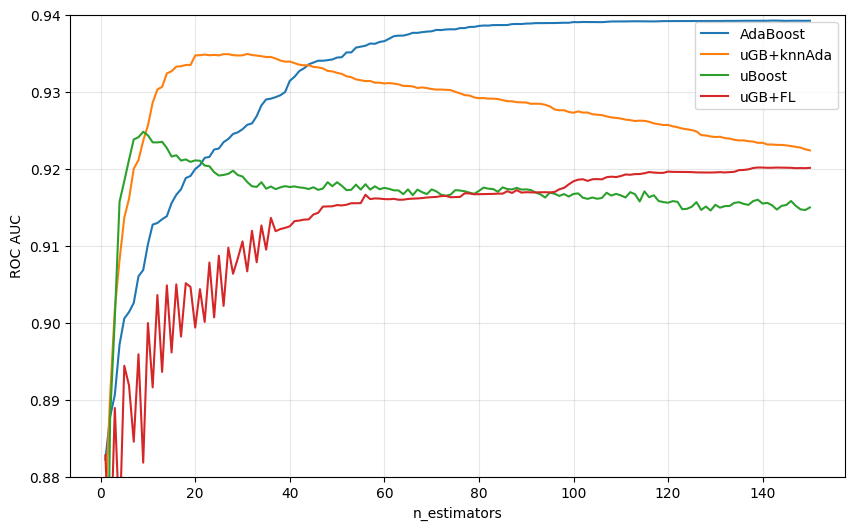

In [14]:
# Helper function to plot learning curves
def plot_learning_curves(classifiers, testX, testY, metric_name="ROC AUC"):
    for name, clf in classifiers.items():
        if hasattr(clf, "staged_predict_proba"):
            scores = []
            n_estimators = []

            # Get the right test data for each classifier
            if name == "AdaBoost":
                X_test = testX[train_features]
            else:
                X_test = testX

            for i, pred_proba in enumerate(clf.staged_predict_proba(X_test)):
                score = roc_auc_score(testY, pred_proba[:, 1])
                scores.append(score)
                n_estimators.append(i + 1)

            plt.plot(n_estimators, scores, label=name)

    plt.xlabel("n_estimators")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True, alpha=0.3)


plt.figure(figsize=(10, 6))
plt.ylim(0.88, 0.94)
plot_learning_curves(classifiers, testX, testY)

## SDE (squared deviation of efficiency) learning curve
SDE vs the number of built trees. SDE is a metric of nonuniformity &mdash; less is better. 

In [9]:
# We can't easily plot learning curves for custom metrics without rep
# So let's just show the final SDE values
sde_metric = BinBasedSDE(uniform_features, uniform_label=1)
sde_metric.fit(testX, testY)

print("SDE (Squared Deviation of Efficiency) - lower is better:")
for name, clf in classifiers.items():
    if name == "AdaBoost":
        proba = clf.predict_proba(testX[train_features])[:, 1]
    else:
        proba = clf.predict_proba(testX)[:, 1]

    # Convert proba to 2D array if needed
    if proba.ndim == 1:
        proba_2d = np.column_stack([1 - proba, proba])
    else:
        proba_2d = proba

    sde_value = sde_metric(testY, proba_2d, sample_weight=None)
    print(f"{name}: {sde_value:.6f}")

SDE (Squared Deviation of Efficiency) - lower is better:
AdaBoost: 0.132515
uGB+knnAda: 0.087952
uBoost: 0.055638
uGB+FL: 0.042421


## CvM learning curve
CvM is a metric of non-uniformity based on Cramer-von Mises distance. We are using knn (based on neighbours) version here.

In [10]:
# Show final CvM values
cvm_metric = KnnBasedCvM(uniform_features, uniform_label=1)
cvm_metric.fit(testX, testY)

print("CvM (Cramer-von Mises) - lower is better:")
for name, clf in classifiers.items():
    if name == "AdaBoost":
        proba = clf.predict_proba(testX[train_features])[:, 1]
    else:
        proba = clf.predict_proba(testX)[:, 1]

    # Convert proba to 2D array if needed
    if proba.ndim == 1:
        proba_2d = np.column_stack([1 - proba, proba])
    else:
        proba_2d = proba

    cvm_value = cvm_metric(testY, proba_2d, sample_weight=None)
    print(f"{name}: {cvm_value:.6f}")

CvM (Cramer-von Mises) - lower is better:
AdaBoost: 0.022512
uGB+knnAda: 0.013006
uBoost: 0.006393
uGB+FL: 0.005215


# ROC curves after training

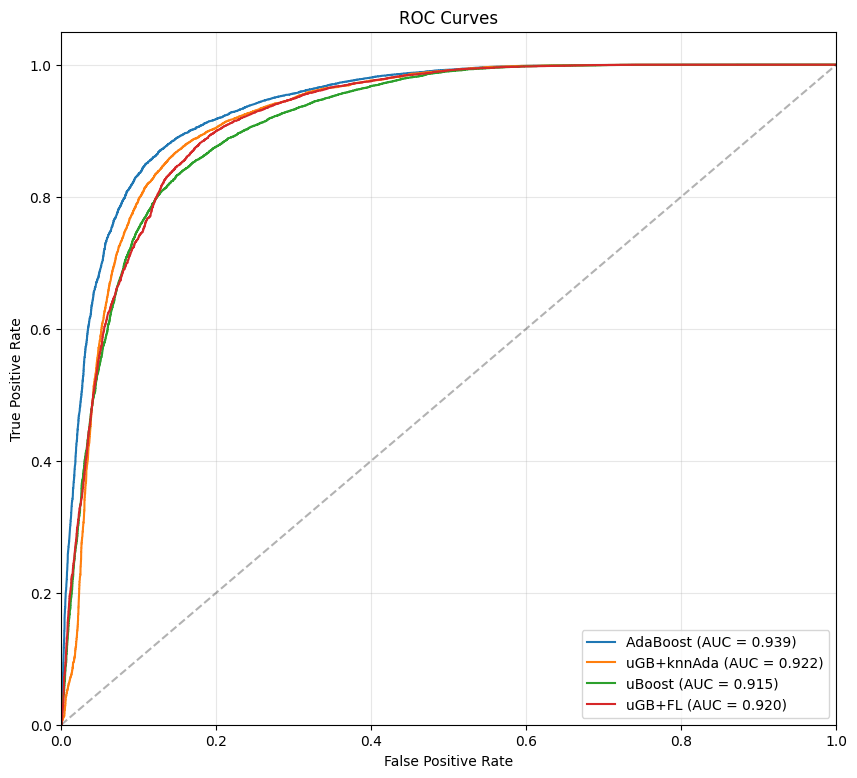

In [11]:
# Plot ROC curves
plt.figure(figsize=[10, 9])

for name, clf in classifiers.items():
    if name == "AdaBoost":
        y_score = clf.predict_proba(testX[train_features])[:, 1]
    else:
        y_score = clf.predict_proba(testX)[:, 1]

    fpr, tpr, _ = roc_curve(testY, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

## Signal efficiency 
global cut corresponds to an average signal efficiency=0.5. In ideal case efficiency in every 2d bin should be close to 0.5.  

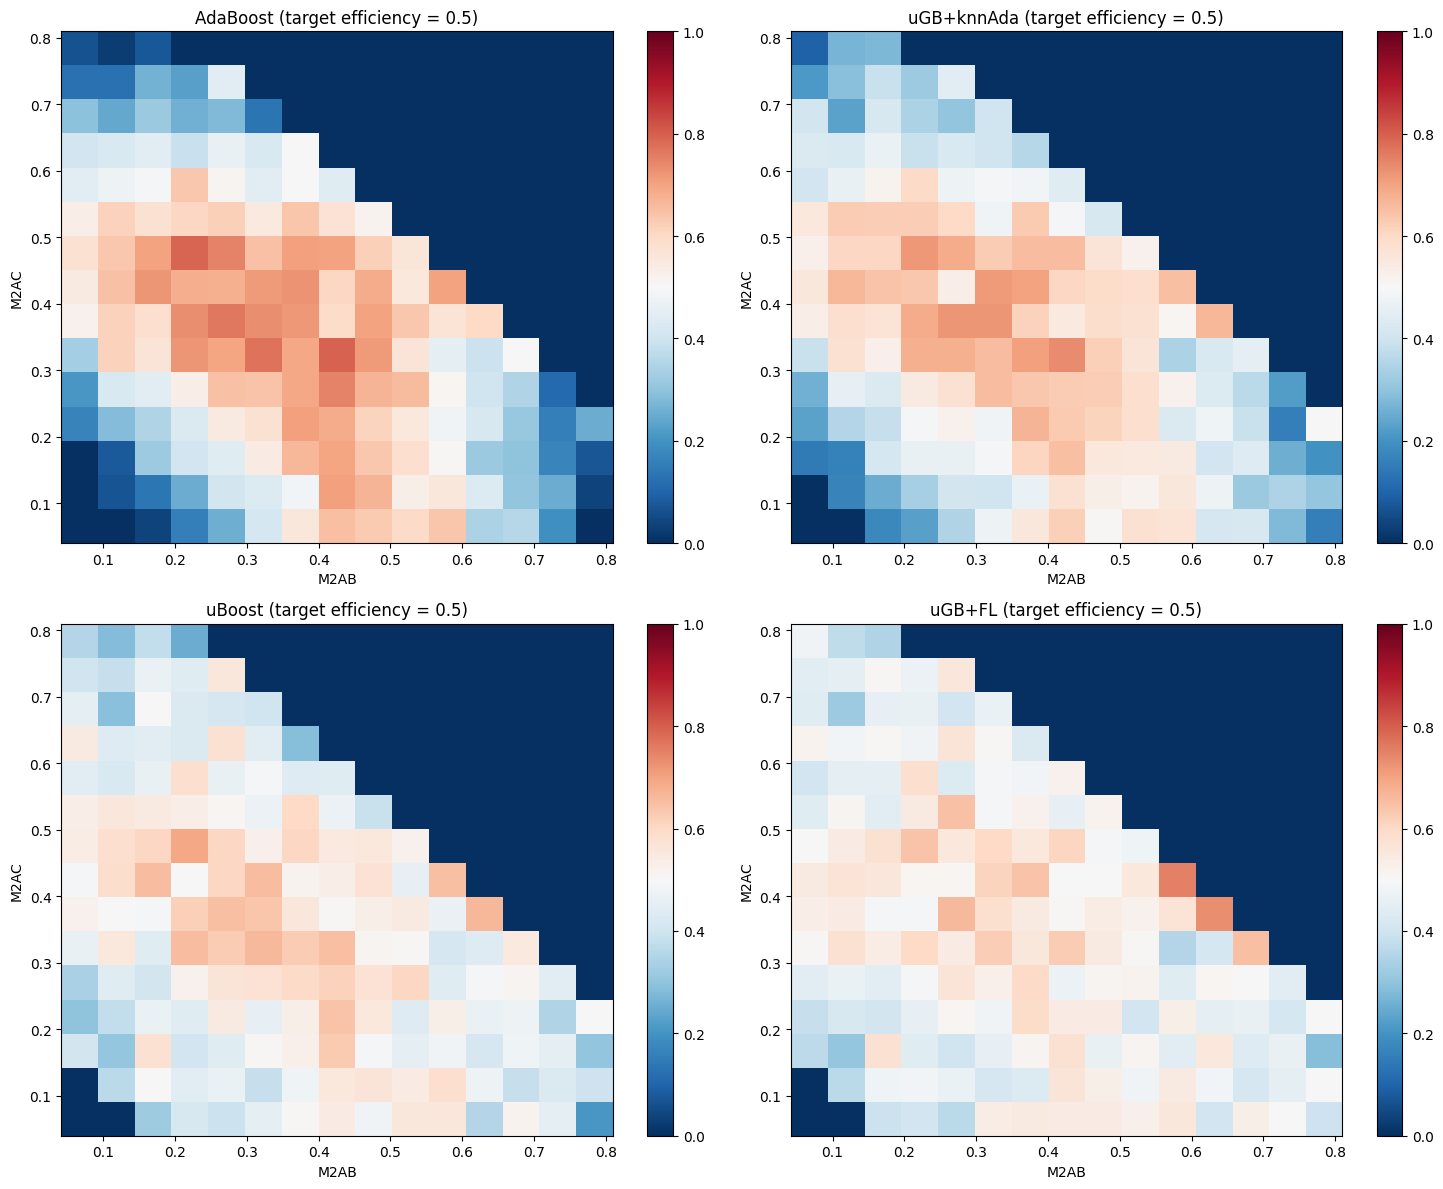

In [12]:
def plot_efficiencies_2d(classifiers, testX, testY, features, efficiency=0.5, signal_label=1, n_bins=15):
    """Plot 2D efficiency maps for all classifiers"""
    signal_mask = testY == signal_label

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, (name, clf) in enumerate(classifiers.items()):
        if idx >= 4:
            break

        ax = axes[idx]

        # Get predictions
        if name == "AdaBoost":
            y_score = clf.predict_proba(testX[train_features])[:, 1]
        else:
            y_score = clf.predict_proba(testX)[:, 1]

        # Find threshold for desired efficiency
        signal_scores = y_score[signal_mask]
        threshold = np.percentile(signal_scores, (1 - efficiency) * 100)

        # Create 2D histogram
        x_data = testX[features[0]][signal_mask]
        y_data = testX[features[1]][signal_mask]
        scores = y_score[signal_mask]

        # Calculate efficiency in each bin
        x_bins = np.linspace(x_data.min(), x_data.max(), n_bins + 1)
        y_bins = np.linspace(y_data.min(), y_data.max(), n_bins + 1)

        efficiency_map = np.zeros((n_bins, n_bins))

        for i in range(n_bins):
            for j in range(n_bins):
                mask = (
                    (x_data >= x_bins[i]) & (x_data < x_bins[i + 1]) & (y_data >= y_bins[j]) & (y_data < y_bins[j + 1])
                )
                if mask.sum() > 0:
                    efficiency_map[j, i] = (scores[mask] >= threshold).mean()

        im = ax.imshow(
            efficiency_map,
            extent=[x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]],
            aspect="auto",
            origin="lower",
            cmap="RdBu_r",
            vmin=0,
            vmax=1,
        )
        ax.set_xlabel(features[0])
        ax.set_ylabel(features[1])
        ax.set_title(f"{name} (target efficiency = {efficiency})")
        plt.colorbar(im, ax=ax)

    plt.tight_layout()
    plt.show()


plot_efficiencies_2d(classifiers, testX, testY, uniform_features, efficiency=0.5, signal_label=1, n_bins=15)

the same for global efficiency = 0.7

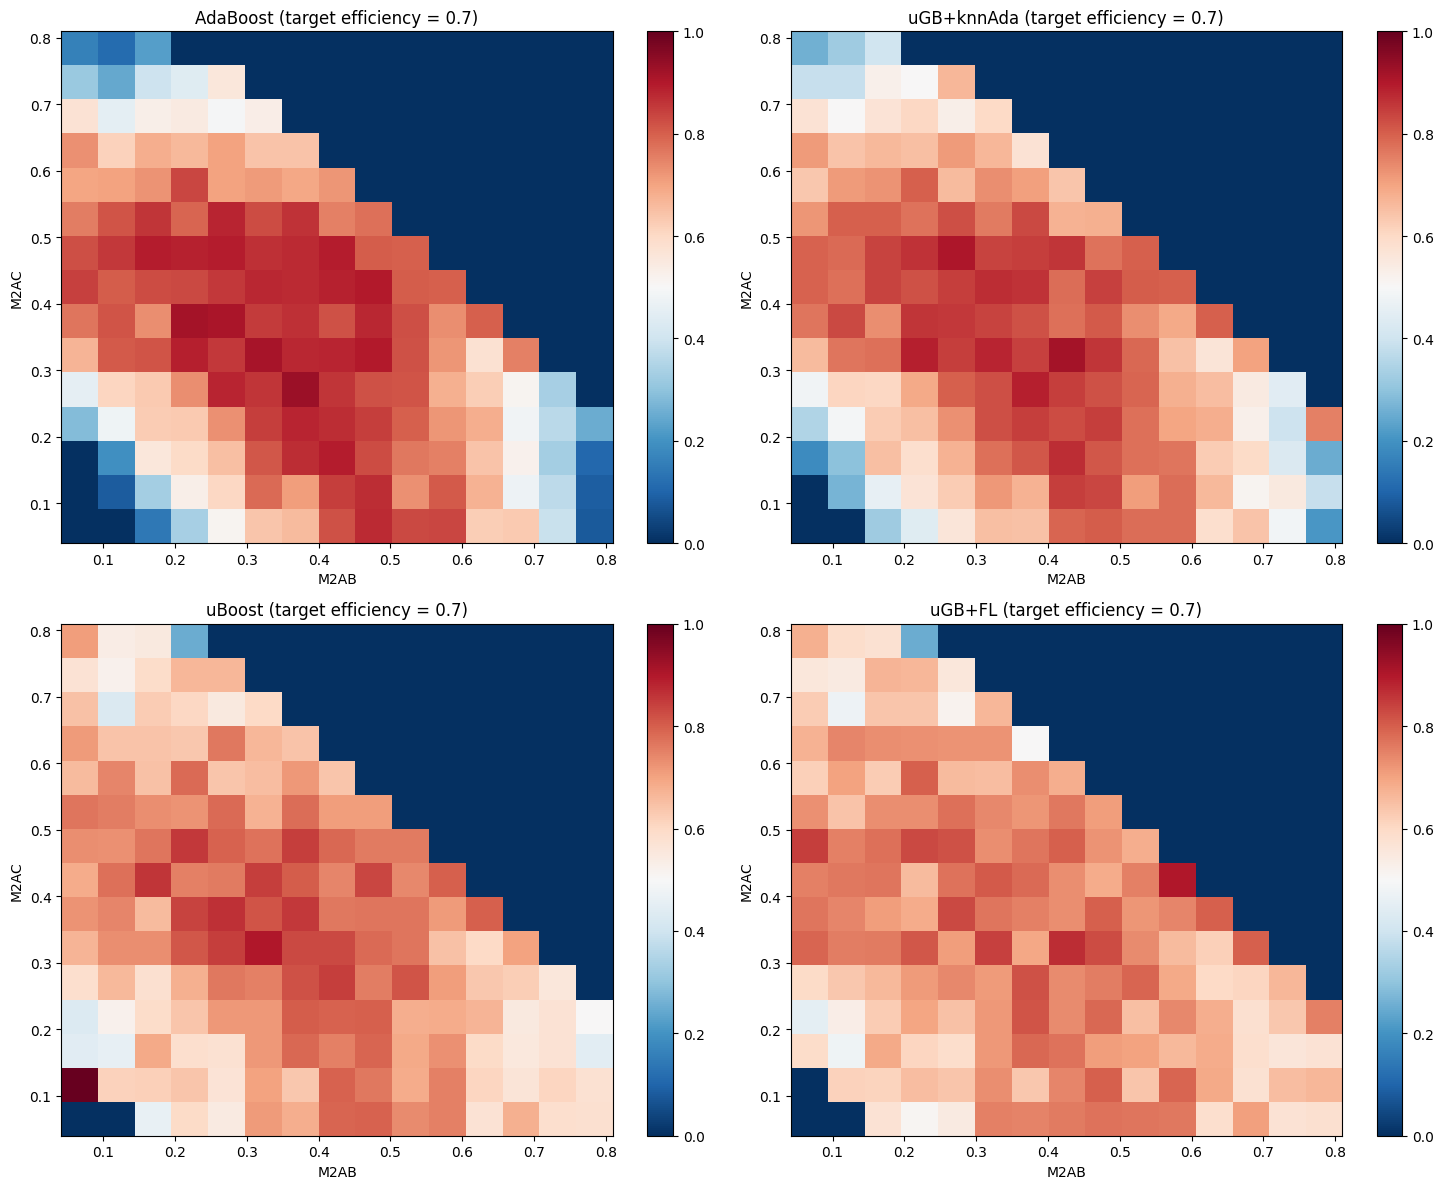

In [13]:
plot_efficiencies_2d(classifiers, testX, testY, uniform_features, efficiency=0.7, signal_label=1, n_bins=15)